In [67]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [68]:
data = pd.read_csv('simulation_data.csv')
data.head()

,k3,k4,k5,k6,class
0,-0.452744,-0.582004,-0.582004,-0.452744,Overshoot
1,-0.250516,0.686300,-0.039354,0.135301,Undershoot
2,-0.399387,0.708746,0.498897,0.708746,Singularity
3,0.149704,0.149704,0.032483,0.032483,Ideal
4,-0.033138,0.504122,0.040915,0.220249,Undershoot


In [69]:
map_data = {'Overshoot': 1, 'Undershoot': 2, 'Ideal': 3, 'Singularity': 4, 'Abnormal': 5}
data['class'] = data['class'].map(map_data)

In [70]:
data

,k3,k4,k5,k6,class
0,-0.452744,-0.582004,-0.582004,-0.452744,1
1,-0.250516,0.686300,-0.039354,0.135301,2
2,-0.399387,0.708746,0.498897,0.708746,4
3,0.149704,0.149704,0.032483,0.032483,3
4,-0.033138,0.504122,0.040915,0.220249,2
...,...,...,...,...,...
1499995,0.259645,0.028643,0.233821,0.214161,1
1499996,456143.342435,89004.676071,79153.249457,920308.283299,5
1499997,0.807450,0.011104,0.081955,0.016689,1
1499998,-0.186917,-0.255762,-0.255762,-0.186917,1


In [71]:
def one_hot_encode_sklearn(data, column_name):
    """
    One-hot encode using scikit-learn's OneHotEncoder.
    
    Parameters:
    data (pandas.DataFrame): Input DataFrame
    column_name (str): Name of the column to encode
    
    Returns:
    pandas.DataFrame: DataFrame with one-hot encoded column
    """
    # Reshape data for encoder
    X = data[column_name].values.reshape(-1, 1)
    
    # Create and fit the encoder
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(X)
    
    # Create new column names
    feature_names = encoder.get_feature_names_out([column_name])

    print(encoded)
    print(feature_names)
    # Create DataFrame with encoded values
    encoded_df = pd.DataFrame(encoded, columns=feature_names, index=data.index)
    
    # Combine with original data
    result = pd.concat([data.drop(column_name, axis=1), encoded_df], axis=1)
    
    return result

In [72]:
encoded_df = one_hot_encode_sklearn(data=data, column_name='class')

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
['class_1' 'class_2' 'class_3' 'class_4' 'class_5']


In [73]:
encoded_df

,k3,k4,k5,k6,class_1,class_2,class_3,class_4,class_5
0,-0.452744,-0.582004,-0.582004,-0.452744,1.0,0.0,0.0,0.0,0.0
1,-0.250516,0.686300,-0.039354,0.135301,0.0,1.0,0.0,0.0,0.0
2,-0.399387,0.708746,0.498897,0.708746,0.0,0.0,0.0,1.0,0.0
3,0.149704,0.149704,0.032483,0.032483,0.0,0.0,1.0,0.0,0.0
4,-0.033138,0.504122,0.040915,0.220249,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1499995,0.259645,0.028643,0.233821,0.214161,1.0,0.0,0.0,0.0,0.0
1499996,456143.342435,89004.676071,79153.249457,920308.283299,0.0,0.0,0.0,0.0,1.0
1499997,0.807450,0.011104,0.081955,0.016689,1.0,0.0,0.0,0.0,0.0
1499998,-0.186917,-0.255762,-0.255762,-0.186917,1.0,0.0,0.0,0.0,0.0


In [128]:
import xgboost as xgb
from xgboost import XGBRegressor  # for regression
from xgboost import XGBClassifier # for classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

# Prepare your data
# targets = ['Overshoot', 'Undershoot', 'Ideal', 'Singularity']
targets = ['class_1', 'class_2', 'class_3', 'class_4', 'class_5']
X = encoded_df.drop(targets, axis=1)
y = encoded_df[targets]

# First split: separate test set (20% of total data)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, # 20% for testing
    random_state=42
)

# Second split: divide remaining data into train and validation (80% train, 20% validation of remaining data)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2, # 20% of the X_temp for validation ==> 16% for validation and 64% for training
    random_state=42
)

-------------
### Getting to know the training data

In [146]:
print('Total entries in the data = ', len(data))

Total entries in the data =  1500000


In [143]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df.head()

,k3,k4,k5,k6,class_1,class_2,class_3,class_4,class_5
854789,-0.417166,-0.361073,0.036083,-0.361073,0.0,0.0,0.0,1.0,0.0
339281,-0.138934,0.059005,0.943825,0.059005,0.0,0.0,0.0,1.0,0.0
179076,-0.488726,-0.591681,0.903061,-0.591681,0.0,0.0,0.0,1.0,0.0
436569,-0.118585,-0.118585,-0.066883,-0.066883,0.0,0.0,1.0,0.0,0.0
1283700,-0.280170,-0.280170,-0.126730,-0.126730,0.0,0.0,1.0,0.0,0.0


In [144]:
print('Number of overshoot : ', np.sum(train_df['class_1']))
print('Number of undershoot : ', np.sum(train_df['class_2']))
print('Number of Ideal : ', np.sum(train_df['class_3']))
print('Number of Singularity : ', np.sum(train_df['class_4']))
print('Number of Abnormal : ', np.sum(train_df['class_5']))

Number of overshoot :  218319.0
Number of undershoot :  165240.0
Number of Ideal :  192350.0
Number of Singularity :  192135.0
Number of Abnormal :  191956.0


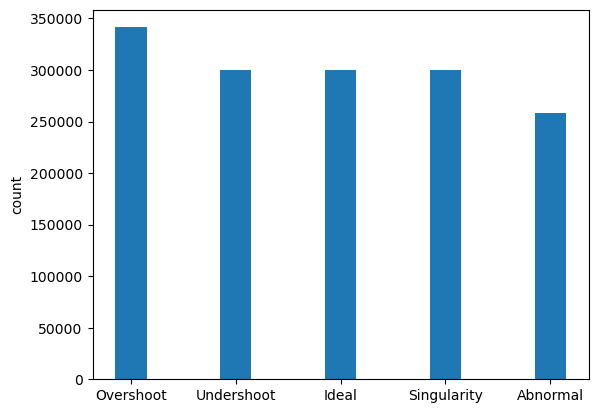

In [154]:
# plt.figure()
# plt.hist(data['class'])
# plt.xticks(['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal'])
# plt.show()
# Get value counts of the classes
class_counts = data['class'].value_counts()

plt.figure()
plt.bar(range(len(class_counts)), class_counts.values, width=0.3)
plt.ylabel('count')
plt.xticks(range(len(class_counts)), ['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal'])
plt.show()

-------------------

In [155]:
# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters
params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',  # for classification
    'eval_metric': 'logloss'
}

# Specify evaluation sets
evals = [(dtrain, 'train'), (dval, 'validation')]

In [156]:
# Train model
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=True
)

[0]	train-logloss:0.46530	validation-logloss:0.46531
[1]	train-logloss:0.43660	validation-logloss:0.43660
[2]	train-logloss:0.41037	validation-logloss:0.41036
[3]	train-logloss:0.38788	validation-logloss:0.38788
[4]	train-logloss:0.36967	validation-logloss:0.36967
[5]	train-logloss:0.35384	validation-logloss:0.35385
[6]	train-logloss:0.34087	validation-logloss:0.34087
[7]	train-logloss:0.32773	validation-logloss:0.32773
[8]	train-logloss:0.31691	validation-logloss:0.31691
[9]	train-logloss:0.30670	validation-logloss:0.30671
[10]	train-logloss:0.29863	validation-logloss:0.29864
[11]	train-logloss:0.29028	validation-logloss:0.29030
[12]	train-logloss:0.28369	validation-logloss:0.28372
[13]	train-logloss:0.27809	validation-logloss:0.27812
[14]	train-logloss:0.27176	validation-logloss:0.27180
[15]	train-logloss:0.26708	validation-logloss:0.26711
[16]	train-logloss:0.26007	validation-logloss:0.26014
[17]	train-logloss:0.25485	validation-logloss:0.25490
[18]	train-logloss:0.25106	validation-

In [157]:
model.save_model('xgboost_model_onSimulation.json')

In [158]:
# Make predictions
preds = model.predict(dtest)
preds

array([[7.9330027e-01, 4.5913202e-01, 6.2368335e-03, 8.8740446e-02,
        1.1694876e-05],
       [5.4991543e-02, 5.7701595e-02, 8.3494866e-01, 1.5907332e-02,
        1.1694876e-05],
       [3.8110442e-04, 8.9607233e-01, 1.1675073e-03, 7.0548855e-02,
        1.1694876e-05],
       ...,
       [1.2010176e-01, 6.5821743e-01, 2.0008899e-01, 8.9115649e-03,
        1.1694876e-05],
       [3.6172688e-01, 1.6224205e-02, 5.7034141e-01, 7.6930389e-02,
        1.1694876e-05],
       [5.4317685e-03, 7.1176497e-04, 9.9190080e-04, 9.0357202e-01,
        1.1694876e-05]], dtype=float32)

In [159]:
# Convert predictions to DataFrame with named columns
columns = ['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal']
pred_df = pd.DataFrame(preds, index=X_test.index, columns=columns)
pred_df

,Overshoot,Undershoot,Ideal,Singularity,Abnormal
610740,0.793300,0.459132,0.006237,0.088740,0.000012
233172,0.054992,0.057702,0.834949,0.015907,0.000012
1149767,0.000381,0.896072,0.001168,0.070549,0.000012
446241,0.447356,0.003505,0.138109,0.049883,0.000012
31954,0.000090,0.001684,0.001304,0.001869,0.999963
...,...,...,...,...,...
1029425,0.551183,0.050575,0.085382,0.112792,0.000012
130810,0.000540,0.004782,0.000012,0.999690,0.000012
1488340,0.120102,0.658217,0.200089,0.008912,0.000012
49225,0.361727,0.016224,0.570341,0.076930,0.000012


In [160]:
pred_df['predicted_class'] = pred_df.idxmax(axis=1)
pred_df

,Overshoot,Undershoot,Ideal,Singularity,Abnormal,predicted_class
610740,0.793300,0.459132,0.006237,0.088740,0.000012,Overshoot
233172,0.054992,0.057702,0.834949,0.015907,0.000012,Ideal
1149767,0.000381,0.896072,0.001168,0.070549,0.000012,Undershoot
446241,0.447356,0.003505,0.138109,0.049883,0.000012,Overshoot
31954,0.000090,0.001684,0.001304,0.001869,0.999963,Abnormal
...,...,...,...,...,...,...
1029425,0.551183,0.050575,0.085382,0.112792,0.000012,Overshoot
130810,0.000540,0.004782,0.000012,0.999690,0.000012,Singularity
1488340,0.120102,0.658217,0.200089,0.008912,0.000012,Undershoot
49225,0.361727,0.016224,0.570341,0.076930,0.000012,Ideal


In [161]:
test_df = pd.concat([X_test, pd.DataFrame(y_test.idxmax(axis=1), columns=['trueClass']), pred_df['predicted_class']], axis=1)

In [162]:
# pd.concat([X_new, pd.DataFrame(y_new.idxmax(axis=1), columns=['trueClass'])], axis=1)
test_df

,k3,k4,k5,k6,trueClass,predicted_class
610740,0.205109,-0.077791,0.214861,0.296918,class_2,Overshoot
233172,-0.476039,-0.476039,-0.199274,-0.199274,class_3,Ideal
1149767,0.684990,0.814306,0.814306,0.684990,class_2,Undershoot
446241,0.687498,0.359996,-0.037691,0.082973,class_1,Overshoot
31954,954964.787452,847579.907518,943602.196568,687435.249175,class_5,Abnormal
...,...,...,...,...,...,...
1029425,0.158524,-0.155413,0.208302,-0.155413,class_4,Overshoot
130810,-0.357028,-0.548016,0.537567,-0.548016,class_4,Singularity
1488340,-0.414935,-0.379722,0.099209,0.073740,class_2,Undershoot
49225,0.063493,0.063493,0.000553,0.000553,class_3,Ideal


In [163]:
test_df['trueClass'] = test_df['trueClass'].map({'class_1': 'Overshoot', 'class_2': 'Undershoot', 'class_3': 'Ideal', 'class_4': 'Singularity', 'class_5': 'Abnormal'})

In [164]:
test_df

,k3,k4,k5,k6,trueClass,predicted_class
610740,0.205109,-0.077791,0.214861,0.296918,Undershoot,Overshoot
233172,-0.476039,-0.476039,-0.199274,-0.199274,Ideal,Ideal
1149767,0.684990,0.814306,0.814306,0.684990,Undershoot,Undershoot
446241,0.687498,0.359996,-0.037691,0.082973,Overshoot,Overshoot
31954,954964.787452,847579.907518,943602.196568,687435.249175,Abnormal,Abnormal
...,...,...,...,...,...,...
1029425,0.158524,-0.155413,0.208302,-0.155413,Singularity,Overshoot
130810,-0.357028,-0.548016,0.537567,-0.548016,Singularity,Singularity
1488340,-0.414935,-0.379722,0.099209,0.073740,Undershoot,Undershoot
49225,0.063493,0.063493,0.000553,0.000553,Ideal,Ideal


In [165]:
Accuracy = (np.sum(test_df['trueClass']==test_df['predicted_class'])/len(test_df['trueClass']))*100
print(f'Accuracy of the prediction = {np.round(Accuracy,2)}%')

Accuracy of the prediction = 94.73%


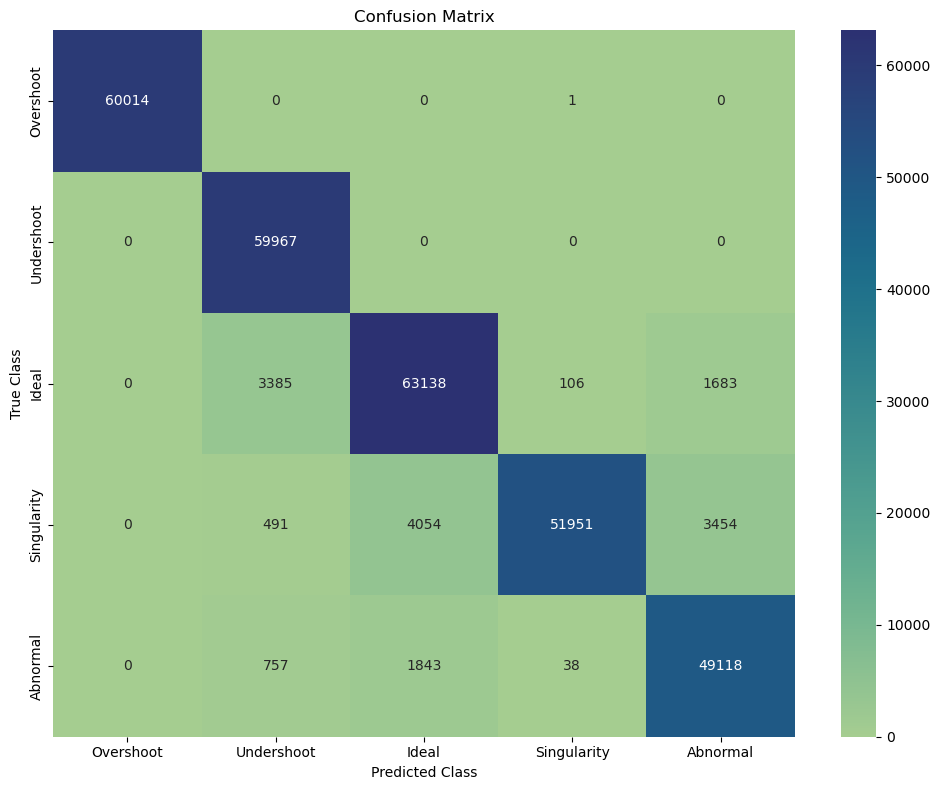

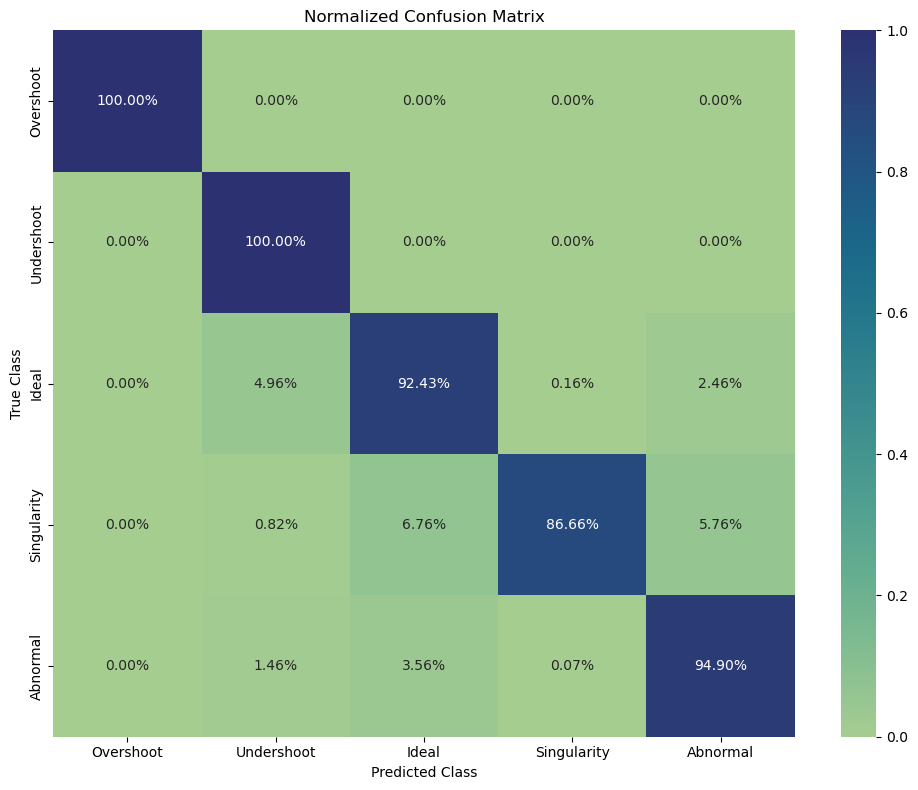

In [166]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_true=test_df['trueClass'], y_pred=test_df['predicted_class'])

# Create a figure and axis
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
            xticklabels=['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal'],  # If your classes are 0-4
            yticklabels=['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal'])  # If your classes are 0-4

# Add labels
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')

# Show plot
plt.tight_layout()
plt.show()

# If you want to normalize the confusion matrix (show percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='crest',
            xticklabels=['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal'],
            yticklabels=['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()
# {'class_1': 'Overshoot', 'class_2': 'Undershoot', 'class_3': 'Ideal', 'class_4': 'Singularity', 'class_5': 'Abnormal'}

In [167]:
(100+100+92.43+86.66+94.90)/5

94.798